In [162]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

save_model = './training_model2.h5'


# %%


In [163]:
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df
#def handleData(df):
   # df = readDataFromFile(source_file_path)

    # df['PRIORITY'] = df['PRIORITY'].astype(str)
    # df['IS_MAIN_ROUTE'] = df['IS_MAIN_ROUTE'].astype(str)

    # df['DATA_DATE'] = df['DATA_DATE'].astype(str)
    # df = df.loc[df['LOT_TYPE']=='FDY']
    # df = df.loc[df['LAYER']!='XX']

    # # df.fillna(0, inplace=True)
    # df = df.assign(PROCESSED_DAYS = ((pd.to_datetime(df['DATA_DATE'], format='%Y%m%d')-pd.to_datetime(df['WS_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))
    # df = df.assign(REMAIN_DAYS = ((pd.to_datetime(df['ACTUAL_WP_OUT'], format='%Y%m%d')-pd.to_datetime(df['DATA_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))

    # df2 = df.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','LAYER','LOT_ID'])

    # labelencoder = LabelEncoder()
    # df2['PRIORITY'] = labelencoder.fit_transform(df2['PRIORITY'])
    # df2['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2['IS_MAIN_ROUTE'])
    # df2['STATUS'] = labelencoder.fit_transform(df2['STATUS'])
    # df2['CHIPNAME'] = labelencoder.fit_transform(df2['CHIPNAME'])

    # df3 = df2.drop(df2.loc[:, '0I':'UG'].columns, axis = 1) 
    # # df3.info()

    
def training(df):
    X_dropped = np.asarray(df3.drop('MOVE_QTY', axis=1))
    Y_dropped = np.asarray(df3['MOVE_QTY'])

    #將Layer放入Model中
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=8,input_shape=[X_dropped.shape[1]]),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Dense(units=64),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=1)
        ])
    model.summary()
    print("\n[Info] 訓練中...")  
    # 定義 tensorboard callback
    tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs')]
    #======================================================================================
    #compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
    #root_mean_squared_error
    from tensorflow.keras import backend as K 
    def root_mean_squared_error(y_true, y_pred): 
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    # model.compile(optimizer = "rmsprop", loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
    model.compile(optimizer = "adam", loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
    #-----------------------------------
    #mean_squared_error
    #model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01), metrics=['accuracy'], callbacks=tensorboard_callback) 
    #======================================================================================
    
    # train_history = model.fit(x=X_dropped, y=Y_dropped,
    #                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
    #                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
    train_history = model.fit(x=X_dropped, y=Y_dropped,
                #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
                validation_split=0.20, epochs=50, batch_size=32, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
    # train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2)
    # train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
    print("Finished training the model")
    model.save(save_model)

    plt.xlabel('Epoch Number')
    plt.ylabel("Loss Magnitude")
    plt.plot(train_history.history['loss'])
    plt.show()
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

    # history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
    # print("Finished training the model")
    # model.save(save_model)

    # plt.xlabel('Epoch Number')
    # plt.ylabel("Loss Magnitude")
    # plt.plot(history.history['loss'])
    # plt.show()

In [164]:
def Testing(source_file_path):
    df_test = pd.read_excel(source_file_path)

    df_test['PRIORITY'] = df_test['PRIORITY'].astype(str)
    df_test['IS_MAIN_ROUTE'] = df_test['IS_MAIN_ROUTE'].astype(str)

    df_test['DATA_DATE'] = df_test['DATA_DATE'].astype(str)
    df_test = df_test.loc[df_test['LOT_TYPE']=='FDY']
    df_test = df_test.loc[df_test['LAYER']!='XX']

    df_test = df_test.assign(PROCESSED_DAYS = ((pd.to_datetime(df_test['DATA_DATE'], format='%Y%m%d')-pd.to_datetime(df_test['WS_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))
    df_test = df_test.assign(REMAIN_DAYS = ((pd.to_datetime(df_test['ACTUAL_WP_OUT'], format='%Y%m%d')-pd.to_datetime(df_test['DATA_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))

    df_test2 = df_test.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','LAYER','LOT_ID'])

    labelencoder = LabelEncoder()
    df_test2['PRIORITY'] = labelencoder.fit_transform(df_test2['PRIORITY'])
    df_test2['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df_test2['IS_MAIN_ROUTE'])
    df_test2['STATUS'] = labelencoder.fit_transform(df_test2['STATUS'])
    df_test2['CHIPNAME'] = labelencoder.fit_transform(df_test2['CHIPNAME'])

    df_test3 = df_test2.drop(df_test2.loc[:, '0I':'UG'].columns, axis = 1) 
    
    X_Test = np.asarray(df_test3.drop('REMAIN_DAYS', axis=1))
    Y_Test = np.asarray(df_test3['REMAIN_DAYS'])

    # df_test3.info()
    model = tf.keras.models.load_model(save_model)
    # print(model.predict(df_test3))

    # plt.xlabel('Seq Number')
    plt.ylabel("Remain Days")

    plt.plot(model.predict(X_Test), label = "Predict", color='red', marker='.',linewidth = '0.5')
    plt.legend()
    plt.show()

In [165]:
#Training('.homework/training_data_20210226.csv')
# Testing('D:/Documents/機器學習/Data/Testing_Data.xlsx')

In [166]:
df_train =readDataFromFile('./training_data_20210226.csv')




In [167]:
# 查看缺失情况
missing = df_train.isna().sum()
missing = pd.DataFrame(data={'特征': missing.index,'缺失值个数':missing.values})
missing

,特征,缺失值个数
0,MFG_DATE,0
1,TOOLG_ID,0
2,TOOLG_ID_NEXT,92
3,WIP_QTY,0
4,MOVE_QTY,0
5,M,12
6,U,13
7,PT,0
8,UP_TIME,1
9,EQP_UTIL,1


In [168]:
df_train['Finish']=np.where(df['TOOLG_ID_NEXT'].isnull(), 1, 0)       

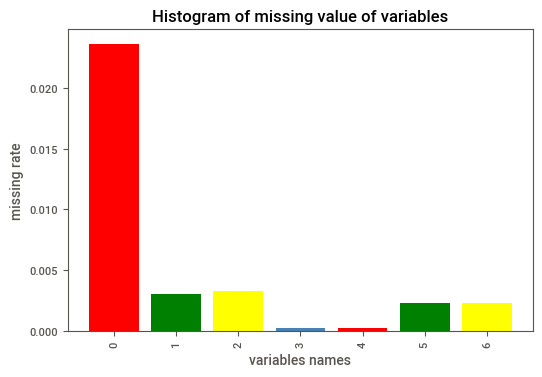

In [169]:
# 去掉标签
X_missing = df_train#.drop(['survived'],axis=1)

# 查看缺失情况
missing = X_missing.isna().sum()
missing = pd.DataFrame(data={'特征': missing.index,'缺失值个数':missing.values})
#通过~取反，选取不包含数字0的行
missing = missing[~missing['缺失值个数'].isin([0])]
# 缺失比例
missing['缺失比例'] =  missing['缺失值个数']/X_missing.shape[0]
missing
# 排序
missing.sort_values(by='缺失比例',ascending=False)

#柱形图可视化
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
fig = plt.figure()#figsize=(18,6))
plt.bar(np.arange(missing.shape[0]), list(missing['缺失比例'].values), align = 'center',color=['red','green','yellow','steelblue'])
plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
# 添加x轴标签，并旋转90度
#plt.xticks(np.arange(missing.shape[0]),list(missing['特征']))
plt.xticks(rotation=90)
# 添加数值显示
# for x,y in enumerate(list(missing['缺失比例'].values)):
#     plt.text(x,y*-0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
    
#     plt.xticks(rotation=90)
# 添加数值显示
# for x,y in enumerate(list(missing['缺失比例'].values)):
#     plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
#plt.ylim([0,1.2])
plt.show()
 

In [170]:
df_train.describe()

,MFG_DATE,WIP_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,CA,CS,Finish
count,3.898000e+03,3898.000000,3898.000000,3886.000000,3885.000000,3898.000000,3897.000000,3897.000000,3.889000e+03,3.889000e+03,3898.000000
mean,2.020417e+07,483.195998,2115.756157,4.826150,0.684285,4289.813274,0.933258,0.779015,9.819214e+06,9.262739e+06,0.023602
std,4.227961e+03,2499.138497,6485.535537,5.785274,0.586407,9377.884549,0.098282,0.232470,4.024248e+07,3.930272e+07,0.151825
min,2.020110e+07,0.000000,0.500000,0.000000,0.002985,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,2.020112e+07,0.000000,75.000000,1.900273,0.243333,265.857871,0.915181,0.717158,1.858605e+05,1.418136e+05,0.000000
50%,2.020122e+07,25.000000,325.000000,3.449388,0.593750,1546.761982,0.964067,0.850901,6.105353e+05,4.785987e+05,0.000000
75%,2.021011e+07,100.000000,1156.500000,4.743428,0.921187,3031.922803,0.994597,0.939447,1.503479e+06,1.106681e+06,0.000000
max,2.021013e+07,27122.000000,45652.000000,38.027170,3.483951,61081.909091,1.000000,1.000000,6.945724e+08,6.805913e+08,1.000000


In [171]:
# 2	TOOLG_ID_NEXT	92	0.023602
# 5	M	12	0.003079
# 6	U	13	0.003335
# 8	UP_TIME	1	0.000257
# 9	EQP_UTIL	1	0.000257
# 10	CA	9	0.002309
# 11	CS	9	0.002309
df_train['TOOLG_ID_NEXT'] = df_train['TOOLG_ID_NEXT'].fillna('NA')
# 均值填充
df_train['M'] = df_train['M'].fillna(df_train['M'].mean())
df_train['U'] = df_train['U'].fillna(df_train['U'].mean())
# 中位数填充
df_train['UP_TIME'] = df_train['UP_TIME'].fillna(df_train['UP_TIME'].median())
df_train['EQP_UTIL'] = df_train['EQP_UTIL'].fillna(df_train['EQP_UTIL'].median())
# 众数填充
from sklearn.impute import SimpleImputer

# imputer = Imputer(missing_values ="NaN",strategy = "most_frequent",axis = 0)
# # imp_mean = SimpleImputer(missing_values = np.nan, strategy="most_frequent",copy=True)
# # df_train_mean = imp_mean.fit_transform(df_train[:'CS'])
# # df_train_mean
# df_train['CS']=imputer.transform(df_train['CS'].reshape(-1,1))
# imputer = SimpleImputer(missing_values ="nan",strategy = "mean")
# df_train['CS']=imputer.fit_transform(df_train['CS'].values.reshape(-1,1))[:0]
imp = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(df))
# strategy參數：可為"mean"(平均數[預設])、"median"(中位數)、"most_frequent"(眾數[可用於填充文字])、"constant"(常數[可用於填充文字])
# 若使用"constant"(常數)進行填補，則需再指定fill_value參數為何值
# fill_value = 0：使用0進行填補
# copy: 預設為True:創建特徵矩陣的副本 ; 設為False時，會將缺失值直接填補到原本的特徵矩陣中去
# X_missing

[[20201101 'DGM_AM_350' 'PK_DUVKrF' ... 3635820.8056688 1427079.10968744
  0]
 [20201101 'EA_AsherM' 'PK_DUVKrF' ... 267171.797924688 388333.460186064
  0]
 [20201101 'EB_Asher' 'PK_DUVKrF' ... 419874.28164436 1097463.87020019 0]
 ...
 [20210131 'WO_SiO2' 'PK_DUVKrF' ... 3215659.26236882 1574355.66266867 0]
 [20210131 'WY_DK' 'PK_DUVKrF' ... 913623.089013633 680035.173215718 0]
 [20210131 'XE_Sorter' 'PK_DUVKrF' ... 19413.2271045446 20277.0372473823
  0]]


In [172]:

# 1. 查看缺失情况
print(df_train.isnull().sum())
# print(df_test.isnull().sum())
#df_train.dropna() # 刪除null值
#df2_test = df2_test.dropna()# 刪除null值


MFG_DATE         0
TOOLG_ID         0
TOOLG_ID_NEXT    0
WIP_QTY          0
MOVE_QTY         0
M                0
U                0
PT               0
UP_TIME          0
EQP_UTIL         0
CA               9
CS               9
Finish           0
dtype: int64


In [173]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MFG_DATE       3898 non-null   int64  
 1   TOOLG_ID       3898 non-null   object 
 2   TOOLG_ID_NEXT  3898 non-null   object 
 3   WIP_QTY        3898 non-null   int64  
 4   MOVE_QTY       3898 non-null   float64
 5   M              3898 non-null   float64
 6   U              3898 non-null   float64
 7   PT             3898 non-null   float64
 8   UP_TIME        3898 non-null   float64
 9   EQP_UTIL       3898 non-null   float64
 10  CA             3889 non-null   float64
 11  CS             3889 non-null   float64
 12  Finish         3898 non-null   int64  
dtypes: float64(8), int64(3), object(2)
memory usage: 396.0+ KB


In [174]:
df_train[['WIP_QTY2']] = df_train['MOVE_QTY']+df_train['WIP_QTY']

In [175]:
df_train[['ToolPrefix', 'ToolSub']] = df_train['TOOLG_ID'].str.split('_', 1, expand=True)


In [176]:
df_train.describe()

,MFG_DATE,WIP_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,CA,CS,Finish,WIP_QTY2
count,3.898000e+03,3898.000000,3898.000000,3898.000000,3898.000000,3898.000000,3898.000000,3898.000000,3.889000e+03,3.889000e+03,3898.000000,3898.000000
mean,2.020417e+07,483.195998,2115.756157,4.826150,0.684285,4289.813274,0.933266,0.779034,9.819214e+06,9.262739e+06,0.023602,2598.952155
std,4.227961e+03,2499.138497,6485.535537,5.776359,0.585428,9377.884549,0.098271,0.232443,4.024248e+07,3.930272e+07,0.151825,8880.818740
min,2.020110e+07,0.000000,0.500000,0.000000,0.002985,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.500000
25%,2.020112e+07,0.000000,75.000000,1.901335,0.243864,265.857871,0.915245,0.717248,1.858605e+05,1.418136e+05,0.000000,99.000000
50%,2.020122e+07,25.000000,325.000000,3.452527,0.598874,1546.761982,0.964067,0.850901,6.105353e+05,4.785987e+05,0.000000,370.500000
75%,2.021011e+07,100.000000,1156.500000,4.760755,0.920765,3031.922803,0.994595,0.939432,1.503479e+06,1.106681e+06,0.000000,1225.750000
max,2.021013e+07,27122.000000,45652.000000,38.027170,3.483951,61081.909091,1.000000,1.000000,6.945724e+08,6.805913e+08,1.000000,72774.000000


In [177]:
import sweetviz as sv
pairwise_analysis='off' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。

In [182]:
report_train = sv.analyze([df_train, 'train'],
                                target_feat='MOVE_QTY' 
)
report_train.show_html(filepath='Basic_train_report.html'
                                ) # 儲存為html的格式

compare_subsets_report = sv.compare_intra(df_train,
                                          df_train['Finish']==1, # 給條件區分
                                          ['Finish', 'notFinish'], # 為兩個子資料集命名 
                                          target_feat='MOVE_QTY',
                                          )

compare_subsets_report.show_html(filepath='Compare_male_female_report.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)
Report Basic_train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)
Report Compare_male_female_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [33]:
df_train.head()

,MFG_DATE,TOOLG_ID,TOOLG_ID_NEXT,WIP_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,CA,CS,ToolPrefix,ToolSub
0,20201101,DGM_AM_350,PK_DUVKrF,0,75.0,4.333333,0.866667,4210.137255,0.894144,0.964586,3.635821e+06,1.427079e+06,DGM,AM_350
1,20201101,EA_AsherM,PK_DUVKrF,0,25.0,7.912943,0.376807,1660.781202,0.997027,0.837179,2.671718e+05,3.883335e+05,EA,AsherM
2,20201101,EB_Asher,PK_DUVKrF,0,125.0,14.547104,0.484903,2353.752487,0.972583,0.950711,4.198743e+05,1.097464e+06,EB,Asher
3,20201101,EL_Light,PK_DUVKrF,0,700.0,3.882883,1.941441,1533.378378,0.980550,0.896763,2.933828e+05,9.144524e+04,EL,Light
4,20201101,FC_PadOxi,PK_DUVKrF,0,175.0,3.628141,0.302345,11241.889447,0.894738,0.909255,2.588558e+07,2.396351e+07,FC,PadOxi


,MFG_DATE,TOOLG_ID,TOOLG_ID_NEXT,WIP_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,CA,CS,ToolPrefix,ToolSub,WIP_QTY2
0,20201101,DGM_AM_350,PK_DUVKrF,0,75.0,4.333333,0.866667,4210.137255,0.894144,0.964586,3.635821e+06,1.427079e+06,DGM,AM_350,75.0
1,20201101,EA_AsherM,PK_DUVKrF,0,25.0,7.912943,0.376807,1660.781202,0.997027,0.837179,2.671718e+05,3.883335e+05,EA,AsherM,25.0
2,20201101,EB_Asher,PK_DUVKrF,0,125.0,14.547104,0.484903,2353.752487,0.972583,0.950711,4.198743e+05,1.097464e+06,EB,Asher,125.0
3,20201101,EL_Light,PK_DUVKrF,0,700.0,3.882883,1.941441,1533.378378,0.980550,0.896763,2.933828e+05,9.144524e+04,EL,Light,700.0
4,20201101,FC_PadOxi,PK_DUVKrF,0,175.0,3.628141,0.302345,11241.889447,0.894738,0.909255,2.588558e+07,2.396351e+07,FC,PadOxi,175.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3893,20210131,WM_PosCln,PK_DUVKrF,659,6918.0,9.948901,0.621806,2976.063736,1.000000,0.991135,1.358413e+06,8.657739e+05,WM,PosCln,7577.0
3894,20210131,WM_PreCln,PK_DUVKrF,0,50.0,3.902196,0.780439,2449.485030,0.982268,0.985043,5.269941e+05,1.817229e+05,WM,PreCln,50.0
3895,20210131,WO_SiO2,PK_DUVKrF,0,25.0,2.413793,0.804598,5035.844828,0.913641,0.970327,3.215659e+06,1.574356e+06,WO,SiO2,25.0
3896,20210131,WY_DK,PK_DUVKrF,25,100.0,1.747126,0.873563,3237.965517,0.943347,0.886387,9.136231e+05,6.800352e+05,WY,DK,125.0
